In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import cv2 as cv
import pandas as pd
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
def get_dicts(dataframe, im_dir):
        """define a ddataset dictionary for detectron2

        Args:
            dataframe (pd.DataFrame): dataframe with the following columns:
            image_name, bbox, image_id, patient_id

        Returns:
            list: list of dictionaries with the following keys:
            file_name, image_id, height, width, annotations
        """
        dataset_dicts = []
        df = dataframe.copy()

        df['image_id'] = df['image_name'].astype('category').cat.codes


        for _, row in df.iterrows():
            
            record = {}
            
            filename = im_dir / (row["image_name"] + ".jpg")
            height, width = cv.imread(str(filename)).shape[:2]
            
            record["file_name"] = str(filename)
            record["image_id"] = row["image_id"]
            record["height"] = height
            record["width"] = width
            

            bbox_roi = eval(row["bbox"])   
            px = [bbox_roi[0], bbox_roi[0]+bbox_roi[2], bbox_roi[0]+bbox_roi[2], bbox_roi[0]]
            py = [bbox_roi[1], bbox_roi[1], bbox_roi[1]+bbox_roi[3], bbox_roi[1]+bbox_roi[3]]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            objs = []
            obj =  {
                    "bbox": [bbox_roi[0] , bbox_roi[1], bbox_roi[0]+bbox_roi[2], bbox_roi[1]+bbox_roi[3]],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": 0,
                }
            objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)

        return dataset_dicts

In the case of an oracle selecting the models, we will compare the performance directly on the test set.
    This is a non-standard biased way of comparing the models and it is only used for a general comparison of the models.
    - completly stratified comparison will be perfored using training-val-test sets in the following pipelines

In [6]:
def test_inference_at(model_file:Path):

    # configuration model
    config_file = repo_path / 'data/models/config_trained_R_101_30k.yaml'
    assert model_file.exists(), f"Model file not found in {model_file}"

    # test data
    metadata_path = repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/test_set.csv'
    im_dir = repo_path / 'data/CDD-CESM/images/substracted'
    test_dataframe = pd.read_csv(metadata_path)
    # print info
    print(f'Number of patients: {len(test_dataframe["patient_id"].unique())}')
    print(f'Number of lesions: {len(test_dataframe)}')
    print(f'Number of images: {len(test_dataframe["image_name"].unique())}')

    # register the dataset
    registration_name = "CEM_test"
    if registration_name in DatasetCatalog.list():
        DatasetCatalog.remove(registration_name)
        MetadataCatalog.remove(registration_name)
    DatasetCatalog.register(registration_name, lambda: get_dicts(test_dataframe, im_dir))
    MetadataCatalog.get(registration_name).set(thing_classes=["mass"])

    # model setting
    min_score = 0.01 # minimum score to keep prediction
    cfg = get_cfg()
    cfg.merge_from_file(str(config_file))
    cfg.MODEL.WEIGHTS = str(model_file)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score  # set the testing threshold for this model
    cfg.DATASETS.TEST = (registration_name, )
    # define predictor
    predictor = DefaultPredictor(cfg)

    # log info about the model
    print(f'The model min IoU score is: {min_score}')

    # define evaluator
    evaluator = COCOEvaluator(dataset_name=registration_name, distributed=False, output_dir='output', allow_cached_coco=False)
    val_loader = build_detection_test_loader(cfg, registration_name)
    metrics = inference_on_dataset(predictor.model, val_loader, evaluator)

    metrics_df = pd.DataFrame(metrics)

    return metrics_df

def group_inference(model_type:str):
    models_dir = repo_path / 'detection/training/results' / model_type
    # get all files ending with pth
    model_files = [f for f in models_dir.glob('*.pth') if f.is_file()]
    # remove final model
    model_files = [f for f in model_files if 'final' not in f.name]
    model_files.sort()

    general_metrics = None
    for model_file in model_files:
        print(f'Inference for model: {model_file.name}')
        metrics_df = test_inference_at(model_file)
        metrics_df.columns = [f'{model_file.stem.split(sep="_")[1]}' for _ in metrics_df.columns]
        # concat in the column direction
        general_metrics = pd.concat([general_metrics, metrics_df], axis=1) if general_metrics is not None else metrics_df

    return general_metrics


In [7]:
general_metrics_synth = group_inference('real-synth_improved')
general_metrics_real = group_inference('normal_fine-tuning')

Inference for model: model_0004999.pth
Number of patients: 32
Number of lesions: 140
Number of images: 56
[03/03 16:18:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/real-synth_improved/model_0004999.pth ...
The model min IoU score is: 0.01
[03/03 16:18:54 d2.evaluation.coco_evaluation]: Trying to convert 'CEM_test' to COCO format ...
[03/03 16:18:54 d2.data.datasets.coco]: Converting annotations of dataset 'CEM_test' to COCO format ...)
[03/03 16:18:58 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/03 16:18:58 d2.data.datasets.coco]: Conversion finished, #images: 140, #annotations: 140
[03/03 16:18:58 d2.data.datasets.coco]: Caching COCO format annotations at 'output/CEM_test_coco_format.json' ...
[03/03 16:19:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    mass    | 140          |
|     

/home/ricardo/miniconda3/envs/detectron-new/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/03 16:19:05 d2.evaluation.evaluator]: Inference done 11/140. Dataloading: 0.0015 s/iter. Inference: 0.0988 s/iter. Eval: 0.0002 s/iter. Total: 0.1004 s/iter. ETA=0:00:12
[03/03 16:19:10 d2.evaluation.evaluator]: Inference done 95/140. Dataloading: 0.0080 s/iter. Inference: 0.0543 s/iter. Eval: 0.0002 s/iter. Total: 0.0626 s/iter. ETA=0:00:02
[03/03 16:19:13 d2.evaluation.evaluator]: Total inference time: 0:00:08.765448 (0.064929 s / iter per device, on 1 devices)
[03/03 16:19:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.051868 s / iter per device, on 1 devices)
[03/03 16:19:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/03 16:19:13 d2.evaluation.coco_evaluation]: Saving results to output/coco_instances_results.json
[03/03 16:19:13 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[03/03 16:19:13 d2.evaluation.f

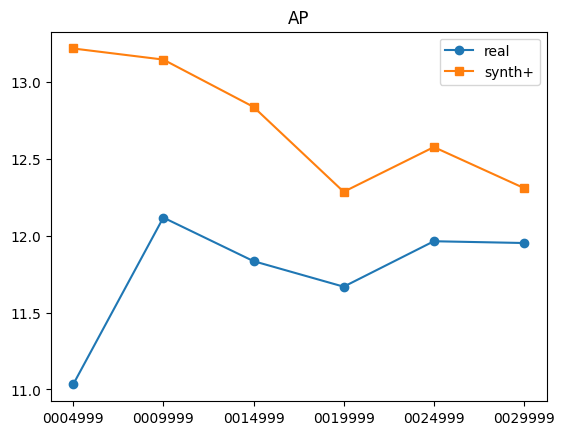

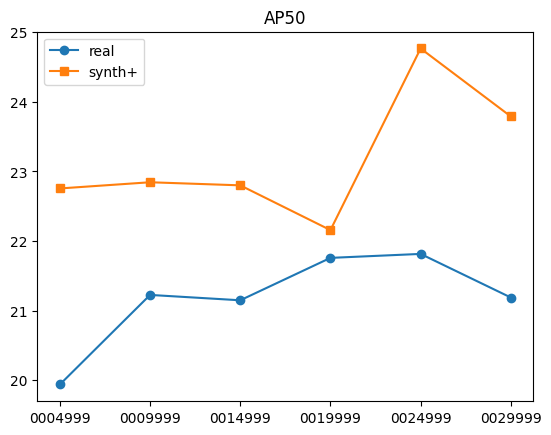

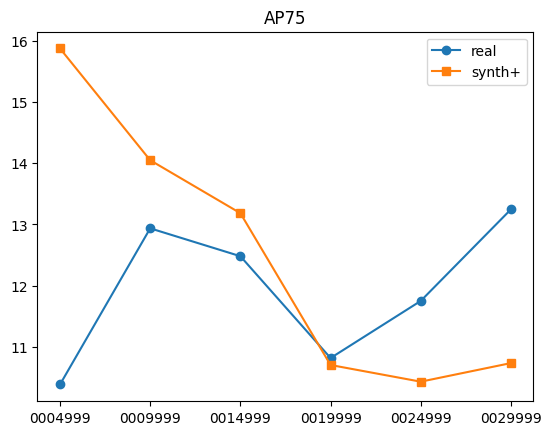

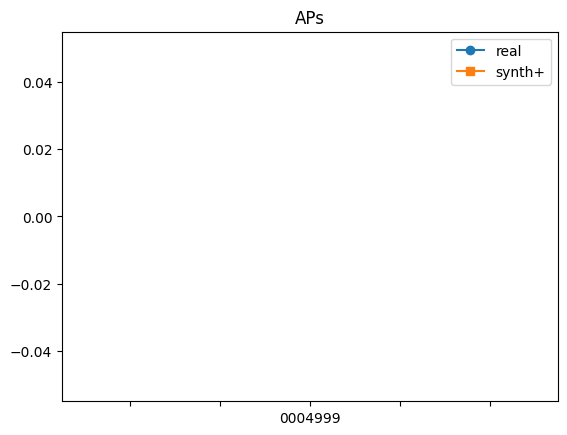

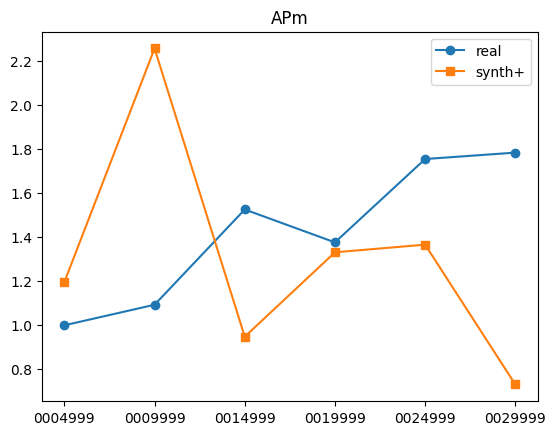

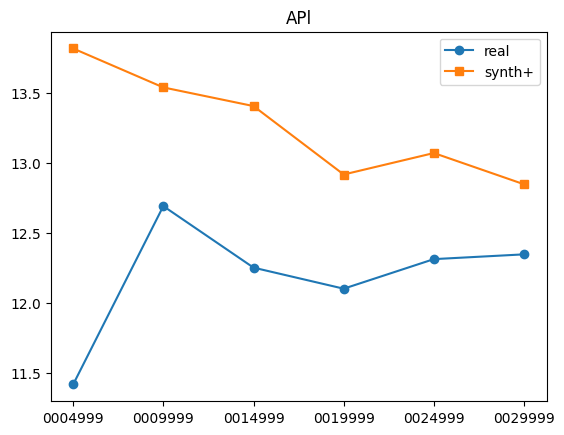

In [8]:
# plot in a unique plot all columns
import matplotlib.pyplot as plt
for index in general_metrics_real.index:
    fig, ax = plt.subplots()
    general_metrics_real.loc[index].plot(kind='line', marker='o', title=index, ax=ax)
    general_metrics_synth.loc[index].plot(kind='line', marker='s', title=index, ax=ax)
    ax.legend(['real', 'synth+'])